# Preprocesamiento del dataset "Sign Language for Numbers"

Este notebook automatiza la descarga, extracción y preprocesamiento de imágenes del dataset de Kaggle ["Sign Language for Numbers"](https://www.kaggle.com/datasets/muhammadkhalid/sign-language-for-numbers).

Ahora el preprocesamiento utiliza MediaPipe Hands para detectar y recortar la mano en cada imagen, y además extrae los puntos clave (landmarks) de la mano para usarlos como características para la predicción.

In [2]:
# Librerías necesarias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp
import pandas as pd
import urllib.request

## 1. Descargar y extraer el dataset desde Kaggle

Necesitas tener configurada la API de Kaggle (`kaggle.json` en `~/.kaggle/`).

In [3]:
dataset_kaggle = "muhammadkhalid/sign-language-for-numbers"
dataset_dir = "Sign Language for Numbers"

# Configura las variables de entorno para la autenticación de Kaggle
os.environ["KAGGLE_USERNAME"] = "andrsarroyavec"
os.environ["KAGGLE_KEY"] = "4b25dc17e4be3312ddb048800c3c2903"

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Descargar y extraer el dataset completo (no un archivo específico)
if not os.path.exists(dataset_dir):
    api.dataset_download_files(dataset_kaggle, path=".", unzip=True)

## 2. Definir rutas y clases

In [4]:
# Carpetas de entrada y salida
input_dir = "Sign Language for Numbers"
output_dir = "preprocessed_numbers"
classes = [str(i) for i in range(10)] + ["unknown"]

In [ ]:
# Crear carpetas de salida
for c in classes:
    os.makedirs(os.path.join(output_dir, c), exist_ok=True)

## 3. Función de preprocesamiento de imágenes con MediaPipe

- Detecta la mano con MediaPipe
- Recorta la región de la mano (con margen)
- Redimensiona a 128x128
- Convierte a escala de grises
- Normaliza a [0,1]
- Extrae los puntos clave (landmarks) de la mano y los retorna como vector

In [5]:
mp_hands = mp.solutions.hands

def get_hand_bbox(landmarks, img_shape, margin=20):
    h, w = img_shape[:2]
    x_coords = [int(l.x * w) for l in landmarks]
    y_coords = [int(l.y * h) for l in landmarks]
    x_min, x_max = max(min(x_coords) - margin, 0), min(max(x_coords) + margin, w)
    y_min, y_max = max(min(y_coords) - margin, 0), min(max(y_coords) + margin, h)
    return x_min, y_min, x_max, y_max

def extract_landmarks(landmarks, img_shape):
    h, w = img_shape[:2]
    # Devuelve un vector plano con las coordenadas normalizadas (x, y, z) de cada punto
    return np.array([[l.x, l.y, l.z] for l in landmarks]).flatten()

def preprocess_image_mediapipe(img_path, size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0].landmark
            x_min, y_min, x_max, y_max = get_hand_bbox(hand_landmarks, img.shape)
            hand_img = img[y_min:y_max, x_min:x_max]
            if hand_img.size == 0:
                return None, None
            hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)
            hand_img = cv2.resize(hand_img, size)
            hand_img = hand_img.astype(np.float32) / 255.0
            landmarks_vec = extract_landmarks(hand_landmarks, img.shape)
            return hand_img, landmarks_vec
        else:
            return None, None

## 3b. Previsualización: Imagen original vs recorte y puntos de la mano

In [6]:
import mediapipe as mp
import urllib.request

def download_mediapipe_model(model_url, model_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if not os.path.exists(model_path):
        print(f"Descargando modelo MediaPipe: {model_path}")
        urllib.request.urlretrieve(model_url, model_path)

# Ruta y URL del modelo necesario para MediaPipe Hands
mp_model_dir = os.path.join(os.path.dirname(mp.__file__), "modules", "hand_landmark")
mp_model_file = os.path.join(mp_model_dir, "hand_landmark_tracking_cpu.binarypb")
mp_model_url = "https://storage.googleapis.com/mediapipe-assets/hand_landmark_tracking_cpu.binarypb"

download_mediapipe_model(mp_model_url, mp_model_file)

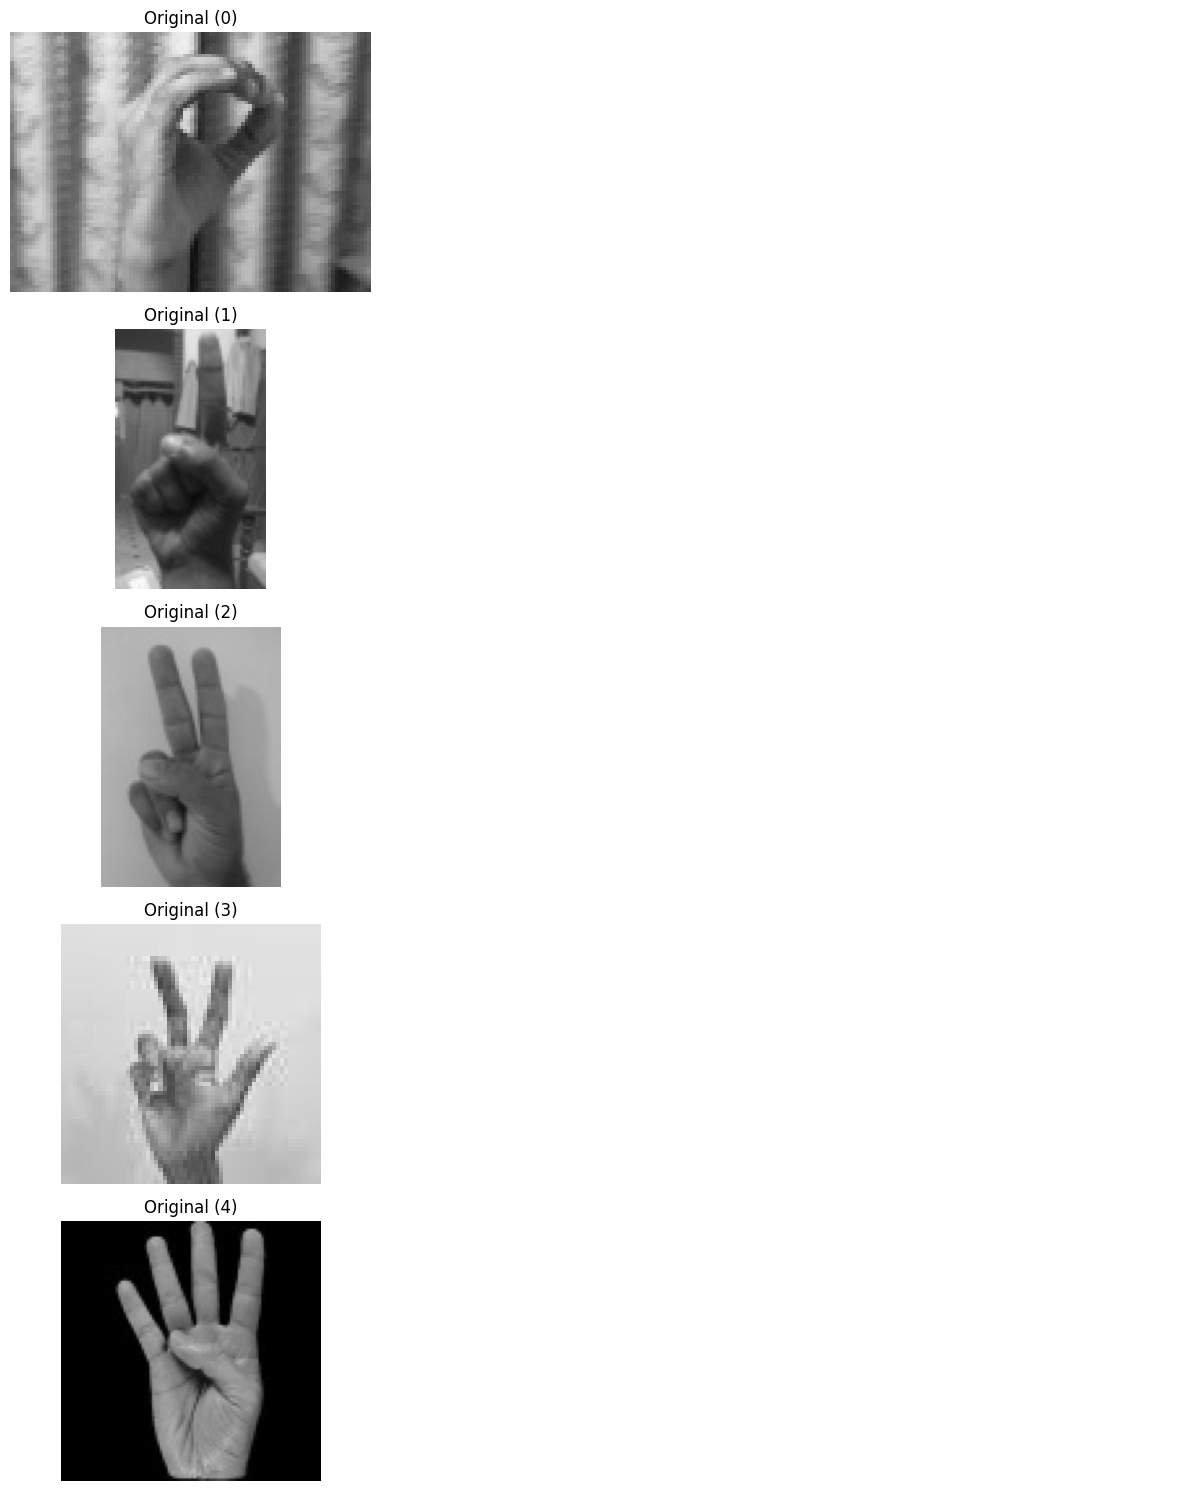

In [7]:
# Selecciona algunas imágenes de ejemplo para mostrar el proceso de recorte y landmarks
ejemplos = []
for c in classes:
    input_class_dir = os.path.join(input_dir, c)
    files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if files:
        ejemplos.append((c, os.path.join(input_class_dir, files[0])))
    if len(ejemplos) >= 5:
        break

mp_drawing = mp.solutions.drawing_utils

fig, axs = plt.subplots(len(ejemplos), 3, figsize=(12, 3*len(ejemplos)))
if len(ejemplos) == 1:
    axs = [axs]  # Para el caso de un solo ejemplo

for idx, (clase, img_path) in enumerate(ejemplos):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[idx][0].imshow(img_rgb)
    axs[idx][0].set_title(f"Original ({clase})")
    axs[idx][0].axis('off')

    # Procesar con mediapipe
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0].landmark
            # Dibuja los puntos sobre la imagen original
            img_landmarks = img_rgb.copy()
            mp_drawing.draw_landmarks(img_landmarks, results.multi_hand_landmarks[0], mp_hands.HAND_CONNECTIONS)
            axs[idx][1].imshow(img_landmarks)
            axs[idx][1].set_title("Original + Landmarks")
            axs[idx][1].axis('off')

            # Recorte y preprocesado
            x_min, y_min, x_max, y_max = get_hand_bbox(hand_landmarks, img.shape)
            hand_img = img[y_min:y_max, x_min:x_max]
            if hand_img.size > 0:
                hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)
                hand_img = cv2.resize(hand_img, (128, 128))
                axs[idx][2].imshow(hand_img, cmap='gray')
                axs[idx][2].set_title("Recorte mano")
                axs[idx][2].axis('off')
            else:
                axs[idx][2].axis('off')
        else:
            axs[idx][1].axis('off')
            axs[idx][2].axis('off')

plt.tight_layout()
plt.show()

## 4. Procesar y guardar imágenes preprocesadas y puntos clave (landmarks)

In [8]:
landmarks_data = []

for c in classes:
    input_class_dir = os.path.join(input_dir, c)
    output_class_dir = os.path.join(output_dir, c)
    if not os.path.exists(input_class_dir):
        print(f"Carpeta no encontrada: {input_class_dir}")
        continue
    files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for fname in tqdm(files, desc=f"Procesando clase {c}"):
        in_path = os.path.join(input_class_dir, fname)
        out_path = os.path.join(output_class_dir, fname)
        img, landmarks_vec = preprocess_image_mediapipe(in_path)
        if img is not None and landmarks_vec is not None:
            cv2.imwrite(out_path, (img * 255).astype(np.uint8))
            # Guardar los landmarks junto con la clase y el nombre de archivo
            landmarks_data.append({
                "class": c,
                "filename": fname,
                **{f"lm_{i}": v for i, v in enumerate(landmarks_vec)}
            })

# Guardar los landmarks en un archivo CSV
if landmarks_data:
    df_landmarks = pd.DataFrame(landmarks_data)
    df_landmarks.to_csv(os.path.join(output_dir, "landmarks.csv"), index=False)

Procesando clase unknown: 100%|██████████| 1500/1500 [01:12<00:00, 20.64it/s]


## 5. Visualizar ejemplos preprocesados y puntos clave

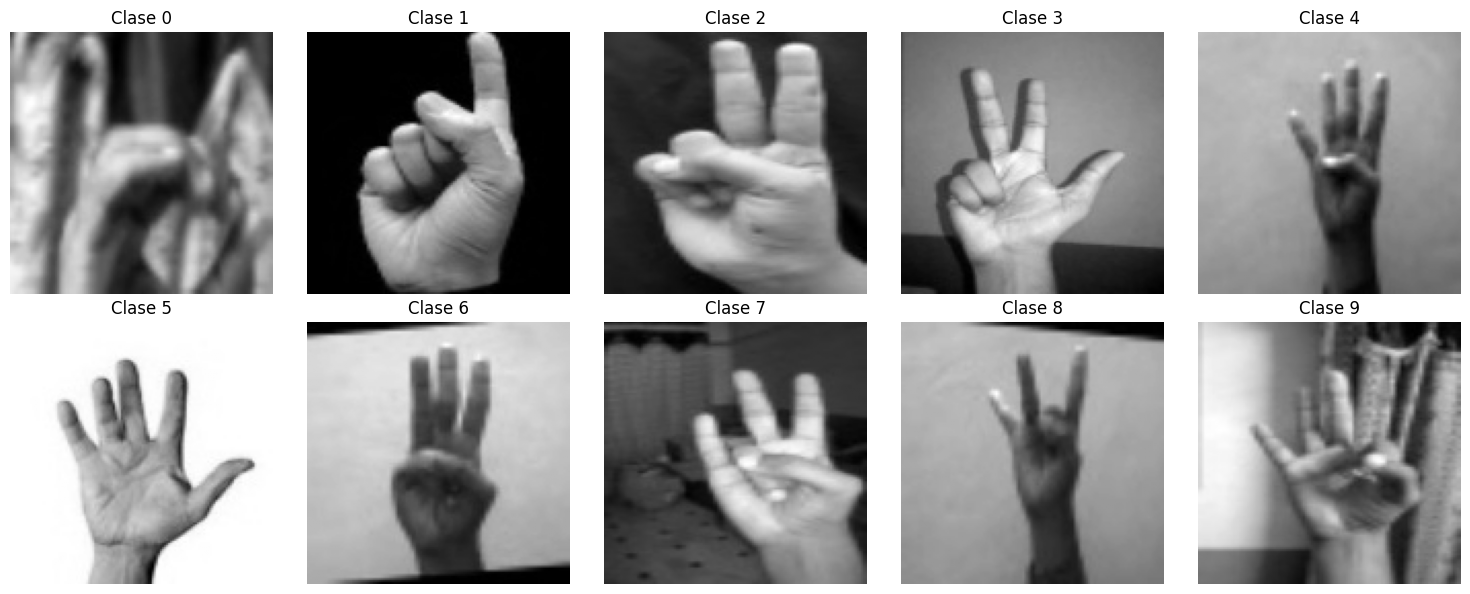

,class,filename,lm_0,lm_1,lm_2,lm_3,lm_4,lm_5,lm_6,lm_7,...,lm_53,lm_54,lm_55,lm_56,lm_57,lm_58,lm_59,lm_60,lm_61,lm_62
0,0,zero_111.jpg,0.459572,0.258764,4.239431e-07,0.506268,0.237772,-0.000453,0.564279,0.216085,...,-0.060235,0.586558,0.209730,-0.073610,0.624734,0.211445,-0.073334,0.656207,0.216367,-0.072565
1,0,zero_135.jpg,0.437552,0.182407,6.039647e-07,0.505517,0.175203,-0.003349,0.576551,0.173406,...,-0.121989,0.523773,0.186519,-0.149882,0.548184,0.205094,-0.152723,0.566381,0.219235,-0.154327
2,0,zero_138.jpg,0.431843,0.641137,5.681268e-07,0.518727,0.567140,-0.005859,0.577026,0.440821,...,-0.085097,0.381653,0.230921,-0.121305,0.450513,0.183411,-0.133552,0.512512,0.177206,-0.135971
3,0,zero_183.jpg,0.398848,0.728660,1.440915e-06,0.558926,0.643488,0.000261,0.648573,0.513114,...,-0.165566,0.541249,0.251293,-0.203958,0.669429,0.241857,-0.195311,0.745828,0.282225,-0.177148
4,0,zero_188.jpg,0.586771,0.253345,4.157754e-07,0.625451,0.273049,-0.014291,0.674022,0.297263,...,-0.037690,0.729616,0.286335,-0.050862,0.752145,0.316287,-0.053639,0.765597,0.346351,-0.054194


In [9]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx, c in enumerate(classes[:10]):
    class_dir = os.path.join(output_dir, c)
    img_files = os.listdir(class_dir)
    img_files = [f for f in img_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if img_files:
        img_path = os.path.join(class_dir, img_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axs[idx//5, idx%5].imshow(img, cmap='gray')
        axs[idx//5, idx%5].set_title(f"Clase {c}")
        axs[idx//5, idx%5].axis('off')
plt.tight_layout()
plt.show()

# Mostrar algunos landmarks
if os.path.exists(os.path.join(output_dir, "landmarks.csv")):
    df_landmarks = pd.read_csv(os.path.join(output_dir, "landmarks.csv"))
    display(df_landmarks.head())

¡Listo! Las imágenes preprocesadas (recortes de mano) y los puntos clave (landmarks) están en la carpeta `preprocessed_numbers`, organizadas por clase y con los landmarks en un archivo CSV.

## 6. Visualizar imágenes preprocesadas con puntos clave sobrepuestas

A continuación se muestran ejemplos de imágenes recortadas con los puntos clave (landmarks) dibujados encima.

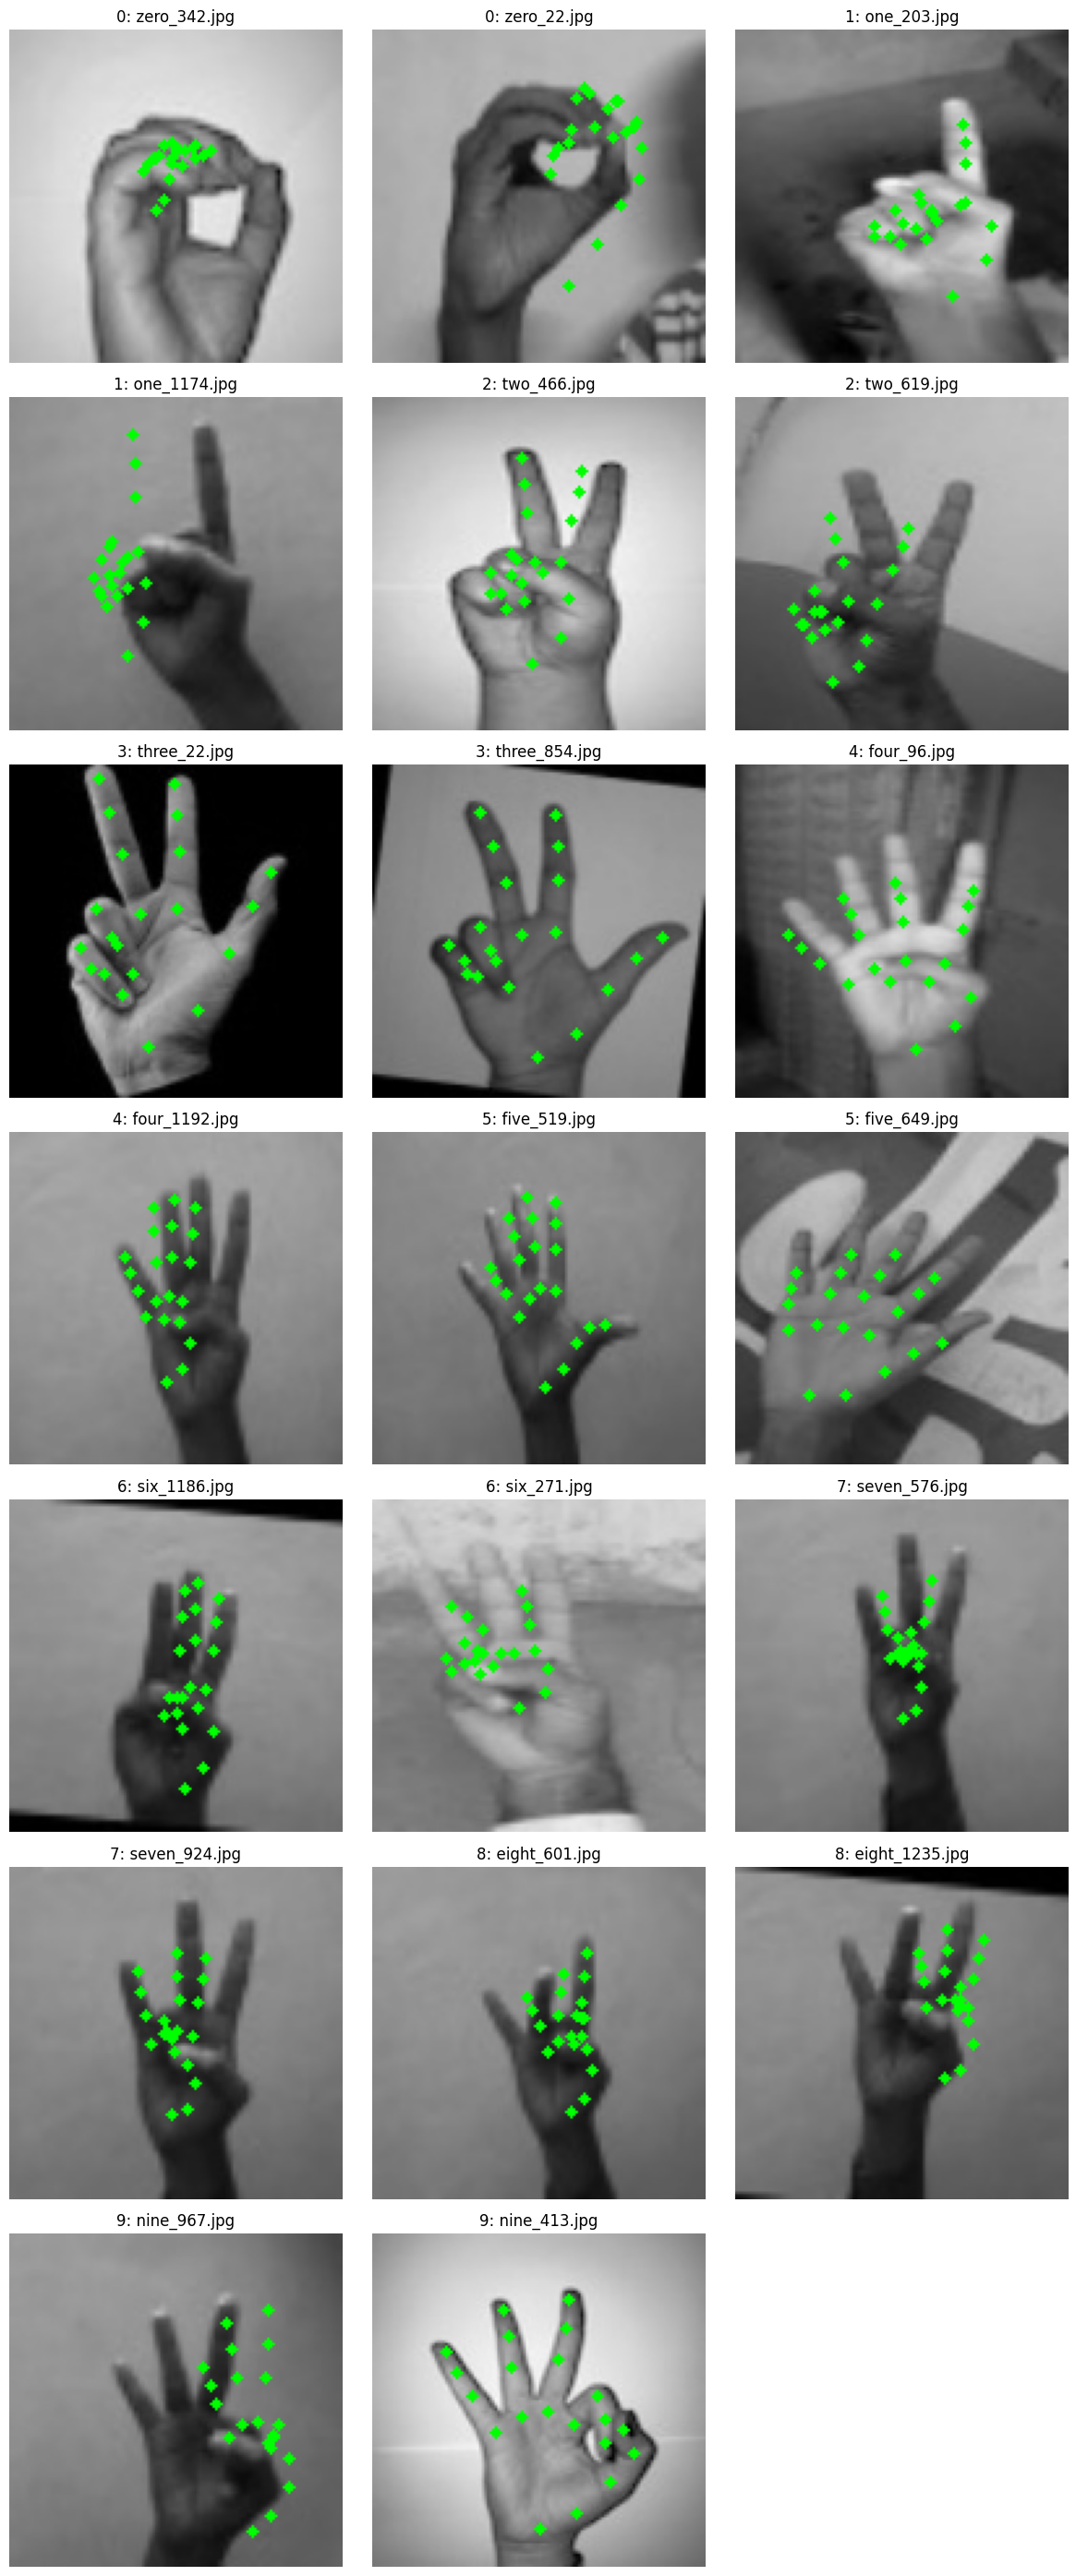

In [ ]:
# Visualizar solo algunos ejemplos de imágenes preprocesadas con los puntos clave sobre ellas
import random

if os.path.exists(os.path.join(output_dir, "landmarks.csv")):
    df_landmarks = pd.read_csv(os.path.join(output_dir, "landmarks.csv"))
    # Selecciona aleatoriamente hasta 2 ejemplos por clase (máximo 10 clases)
    ejemplos = []
    for c in classes[:10]:
        df_c = df_landmarks[df_landmarks["class"] == c]
        if len(df_c) > 0:
            ejemplos += df_c.sample(n=min(2, len(df_c)), random_state=42).to_dict("records")
    n_ejemplos = len(ejemplos)
    ncols = 3
    nrows = (n_ejemplos + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axs = axs.flatten()
    for i, row in enumerate(ejemplos):
        img_path = os.path.join(output_dir, str(row["class"]), row["filename"])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        h, w = img.shape
        # Los landmarks están normalizados respecto a la imagen original, no al recorte.
        # Para que se superpongan correctamente, hay que recalcular los landmarks respecto al recorte.
        # Solución: leer la imagen original, detectar la mano, obtener el bounding box y recalcular.
        # Así, los puntos se dibujan correctamente sobre el recorte.
        # --- Cargar imagen original y recalcular bbox ---
        original_path = os.path.join(input_dir, str(row["class"]), row["filename"])
        original_img = cv2.imread(original_path)
        if original_img is not None:
            img_rgb_draw = img_rgb.copy()
            img_h, img_w = original_img.shape[:2]
            # Reconstruir landmarks normalizados respecto a la imagen original
            landmarks = np.array([row[f"lm_{j}"] for j in range(63)]).reshape(-1, 3)
            # Obtener bbox de la mano en la imagen original
            x_coords = [int(l[0] * img_w) for l in landmarks]
            y_coords = [int(l[1] * img_h) for l in landmarks]
            margin = 20
            x_min, x_max = max(min(x_coords) - margin, 0), min(max(x_coords) + margin, img_w)
            y_min, y_max = max(min(y_coords) - margin, 0), min(max(y_coords) + margin, img_h)
            # Ajustar landmarks al recorte y a la escala 128x128
            for (x, y, z) in landmarks:
                # Coordenadas en la imagen original
                px = x * img_w
                py = y * img_h
                # Coordenadas relativas al recorte
                px_crop = px - x_min
                py_crop = py - y_min
                # Escalar a 128x128
                px_final = int(px_crop * (128 / max(x_max - x_min, 1)))
                py_final = int(py_crop * (128 / max(y_max - y_min, 1)))
                cv2.circle(img_rgb_draw, (px_final, py_final), 2, (0,255,0), -1)
            axs[i].imshow(img_rgb_draw)
        else:
            axs[i].imshow(img_rgb)
        axs[i].set_title(f'{row["class"]}: {row["filename"]}')
        axs[i].axis('off')
    # Oculta los ejes vacíos si hay menos imágenes que subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró el archivo landmarks.csv")